In [1]:
from operator import itemgetter
from collections import OrderedDict
from dataclasses import fields
from itertools import chain
from pathlib import Path
from typing import Tuple, List
import warnings

import matplotlib.pyplot as plt
import xarray as xr
import zarr as zr

from vivarium.core.process import Process
import v2Ecoli.metab.cli as vmc
from v2Ecoli.metab.cli.validate import Perturbation

## Test installation

In [2]:
vmc.main(["test", "-t 30"])


Simulation ID: a0c44202-2ecf-11f0-a1ef-e731450e073e
Created: 05/11/2025 at 18:22:53
Completed in 3.50 seconds


## Simulate: Sensitivity to environment concentrations

In [3]:
model = vmc.find_model()
print(model)
time = 300
perturbations = OrderedDict([
    (("default", "Default"), Perturbation({"GLCx": 1.0, "Px": 1.0}, {"FEED": 1.0})),
    (("no_glc", "No glucose"), Perturbation({"GLCx": .0, "Px": 1.0}, {"FEED": .0})),
    (("no_px", "No phosphate"), Perturbation({"GLCx": 1.0, "Px": .0}, {"FEED": 1.0})),
    (("no_glc_no_px", "No glucose & no phosphate"), Perturbation({"GLCx": .0, "Px": .0}, {"FEED": .0}))
])

/vivarium/vivarium-kecoli/v2Ecoli-metab/src/model/E_coli_Millard2016.xml


In [4]:
res = vmc.validate.perturb_vivarium(model, perturbations.values(), time)


Simulation ID: ac76a2c2-2ecf-11f0-a9bc-e731450e073e
Created: 05/11/2025 at 18:23:13
Completed in 34.66 seconds

Simulation ID: c1eab68c-2ecf-11f0-b70a-e731450e073e
Created: 05/11/2025 at 18:23:49
Completed in 34.62 seconds

Simulation ID: d759c336-2ecf-11f0-8351-e731450e073e
Created: 05/11/2025 at 18:24:25
Completed in 35.83 seconds

Simulation ID: ed8793d2-2ecf-11f0-a81a-e731450e073e
Created: 05/11/2025 at 18:25:02
Completed in 37.44 seconds


## Storage

In [5]:
def to_datatree(
    perturbations: OrderedDict[Tuple[str,...], Perturbation],
    results: List[Tuple[Process, dict]]
) -> xr.DataTree:

    # check perturbation specs
    perturb_keys = [
        set(chain.from_iterable(getattr(p, f.name).keys() for p in perturbations.values()))
        for f in fields(Perturbation)]
    for p in perturbations.values():
        for (f, k) in zip(fields(Perturbation), perturb_keys):
            assert set(getattr(p, f.name).keys()) == k
    perturb_ic, perturb_param = map(list, perturb_keys)

    # check perturbation results
    for (proc, timeseries) in results:
        assert isinstance(proc, Process)
        assert isinstance(timeseries, dict)
    proc = results[0][0]
    timeseries = list(map(itemgetter(1), results))
    extract_emitted = lambda ts, dim: [
        list(map(itemgetter(dim), t)) for t in ts["species_store"]]

    return xr.DataTree.from_dict({
        "/": xr.Dataset(
            coords={
                "species": proc.all_species},
            attrs={
                "model_file": str(proc.parameters["model_file"])}),
        "/perturbations": xr.Dataset(
            data_vars={
                "ic": (
                    ("condition", "perturb_ic"),
                    [[p.ic_factors[f] for f in perturb_ic]
                     for p in perturbations.values()]),
                "param": (
                    ("condition", "perturb_param"),
                    [[p.param_factors[f] for f in perturb_param]
                     for p in perturbations.values()])},
            coords={
                "perturb_ic": perturb_ic,
                "perturb_param": perturb_param,
                "condition": list(map(itemgetter(1), perturbations.keys()))},
            attrs={
                "time_step": proc.parameters["time_step"]}),
        "/perturbations/timeseries": xr.Dataset(
            data_vars={
                "count": (
                    ("condition", "time", "species"),
                    [extract_emitted(ts, 1) for ts in timeseries])},
            coords={
                # if all simulations are statically known to have the same
                # time discretisation, then store as: coords["time"] = dims["time"]
                "time": (
                    ("condition", "time"),
                    [ts["time"] for ts in timeseries])})
    })

In [8]:
trace = to_datatree(perturbations, res);
print(trace)

<xarray.DataTree>
Group: /
│   Dimensions:  (species: 77)
│   Coordinates:
│     * species  (species) <U6 2kB 'ACCOA' 'ACO' 'ACP' 'AKG' ... 'GLCp' 'Pp' 'ACEp'
│   Attributes:
│       model_file:  /vivarium/vivarium-kecoli/v2Ecoli-metab/src/model/E_coli_Mil...
└── Group: /perturbations
    │   Dimensions:        (condition: 4, perturb_ic: 2, perturb_param: 1)
    │   Coordinates:
    │     * perturb_ic     (perturb_ic) <U4 32B 'Px' 'GLCx'
    │     * perturb_param  (perturb_param) <U4 16B 'FEED'
    │     * condition      (condition) <U25 400B 'Default' ... 'No glucose & no phosp...
    │   Data variables:
    │       ic             (condition, perturb_ic) float64 64B 1.0 1.0 1.0 ... 0.0 0.0
    │       param          (condition, perturb_param) float64 32B 1.0 0.0 1.0 0.0
    │   Attributes:
    │       time_step:  1.0
    └── Group: /perturbations/timeseries
            Dimensions:        (condition: 4, time: 301, species: 77)
            Coordinates:
                time           (co

In [9]:
store_path = f"./{Path(trace.attrs['model_file']).name.replace(".xml", ".zip")}"
store = zr.storage.ZipStore(store_path, mode="w")
with warnings.catch_warnings():
    warnings.filterwarnings(action="ignore", message=".*Zarr format 3|.*Duplicate name", category=UserWarning)
    trace.to_zarr(store)
store.close()

## Visualisation

In [10]:
def plot_sensitivity(
    trace: xr.DataTree,
    plot_species=["GLX", "FUM", "PYR", "ACCOA", "AKG", "SUCCOA", "OAA"]
):
    assert isinstance(trace, xr.DataTree)
    sim = trace["/perturbations"]
    plt.rcParams["figure.dpi"] = 120
    fig = plt.figure(constrained_layout=True, figsize=(16, 5))
    plt.suptitle("Sensitivity to perturbations of metabolite availability", fontsize="x-large")
    axs = fig.subplots(nrows=1, ncols=len(sim.condition))
    for (j, (c, ax)) in enumerate(zip(sim.condition, axs)):
        traj = sim["timeseries"].sel(condition=c)
        for sp in plot_species:
            ax.plot(traj["time"].to_numpy(), traj["count"].sel(species=sp).to_numpy(),
                    ls='-', marker='o', markevery=20, label=sp)
        ax.grid(alpha=.3)
        ax.set_title(f"Perturbation: {c.item()}", fontsize="large")
        ax.legend(loc="upper right", fontsize="small")
        ax.set_xlabel("Time (s)")
        if j == 0:
            ax.set_ylabel("Metabolites (mol)")
    plt.show()

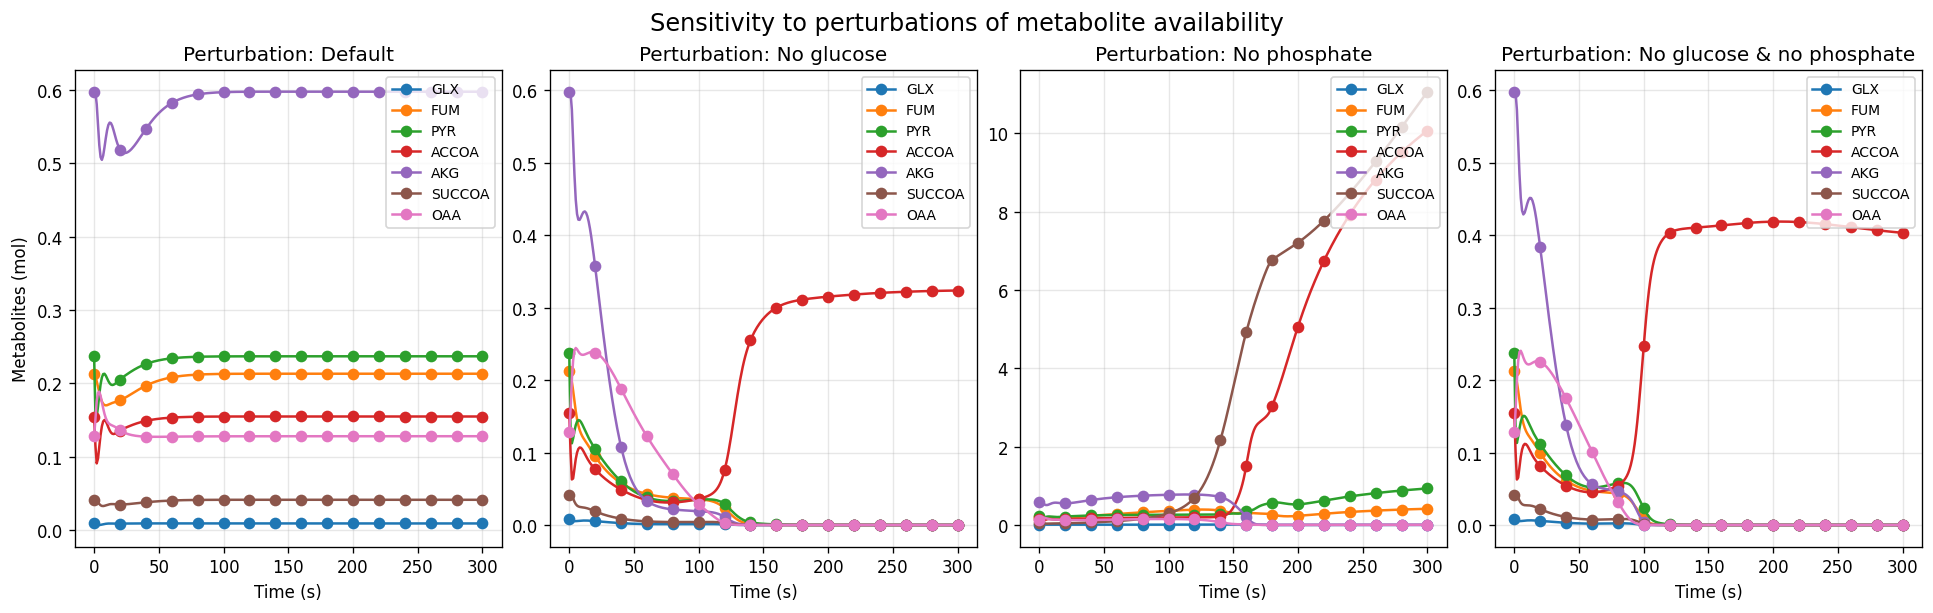

In [11]:
plot_sensitivity(trace)